In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, text, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [9]:
# Inspecting measurement table
for column in inspector.get_columns('measurements'):
    print(column['name'], column['type'])


In [10]:
# Inspecting station table
for column in inspector.get_columns('stations'):
    print(column['name'], column['type'])

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(measurements).order_by(measurements.date.desc()).first()
recent_date.date


'2017-08-23'

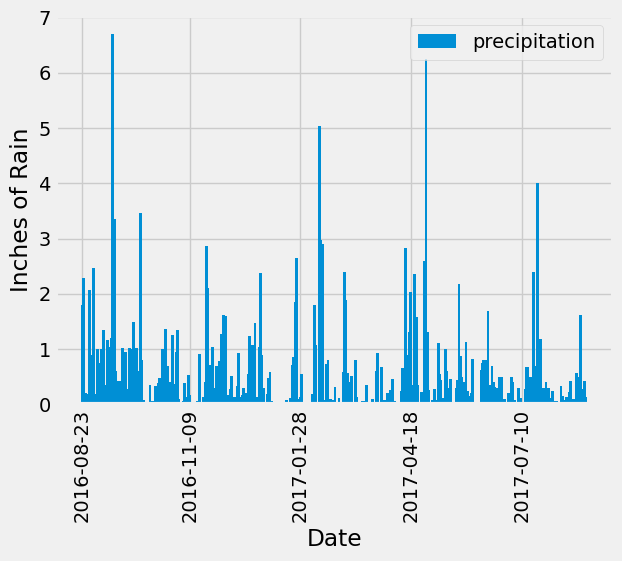

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date
# Calculate the date one year from the last date in data set.
one_year_before = str(pd.to_datetime(recent_date.date) + pd.DateOffset(years = -1))[:10]

# Perform a query to retrieve the data and precipitation scores
data = session.query(measurements.date, measurements.station, measurements.prcp, measurements.tobs).\
    filter(measurements.date >= one_year_before)


#test = session.query(measurement).all()
#for row in test:
    #print(row.date)
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data, columns = ['Date', 'Station', 'PRCP', 'TOBS'])

# Sort the dataframe by date
df.sort_values(by = "Date")
df

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(df['Date'], df['PRCP'], label = "precipitation", width = 2)
plt.xlabel("Date")
plt.ylabel("Inches of Rain")
plt.xticks([0, 78, 158, 238, 319],
           [df['Date'][0], df['Date'][78], df['Date'][158], df['Date'][238], df['Date'][319]], 
           rotation = 90)
plt.legend()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
pd.DataFrame(df['PRCP'].describe())

,PRCP
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
num_station = session.query(stations.station).count() #OR session.query(func.count(station.station)).all()
num_station

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_station = session.query(measurements.station, func.count(measurements.station)).\
    order_by(func.count(measurements.station).desc()).\
    group_by(measurements.station).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stuff = session.query(func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)).\
    filter(measurements.station == active_station[0][0]).first()
temp_stuff


(54.0, 85.0, 71.66378066378067)

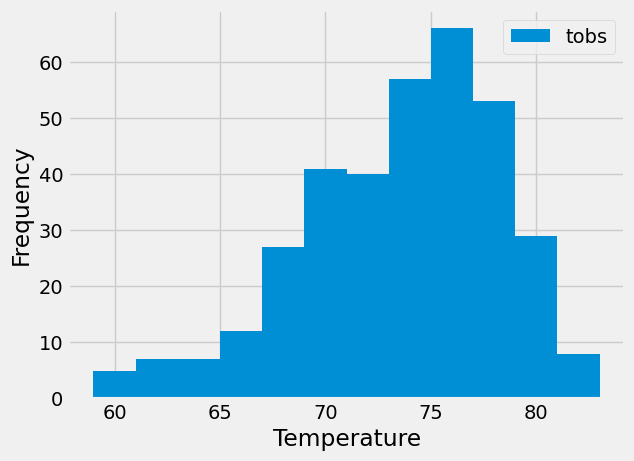

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(measurements.tobs).\
    filter(measurements.date >= one_year_before).\
        filter(measurements.station == active_station[0][0])
temps = []
for temp in data:
    temps.append(temp[0])

plt.hist(temps, bins = 12, label = 'tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Close Session

In [18]:
# Close Session
session.close()